# Growth of stimulus-specific and decision-consistent biases

Behavior data for Figure 3a-d.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import wilcoxon
from statsmodels.stats.weightstats import DescrStatsW

from dynamic_bias import utils
from dynamic_bias.analyses.behavior import StimulusSpecificBias
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/behavior")

behavior = utils.load_behavior()
ssb_fits = utils.load(f'{utils.ORIGIN}/data/outputs/behavior/results_stimulus_specific_bias.pickle')
ssb_weights = utils.load(f'{utils.ORIGIN}/data/outputs/behavior/results_stimulus_specific_bias_weight.pickle')

downloading data/outputs/behavior...
data/outputs/behavior already exists. Skipping download...
downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...


---
## Growth of stimulus-specific bias

In [3]:
ssb = StimulusSpecificBias()
id_list = np.unique(behavior.ID)
stim_list = utils.exp_stim_list(step=0.75)

ssb_fun_list = utils.nan((len(id_list),240))
for i_id, v_id in enumerate(id_list): 
    ssb_fun_list[i_id] = ssb(stim_list, ssb_fits[v_id])

ssb_weight = np.array([[w['E'],w['L']] for _,w in ssb_weights.items()])
m_ssb_fun = np.mean(ssb_fun_list[:,:,np.newaxis]*ssb_weight[:,np.newaxis,:], axis=0)
s_ssb_fun = np.std(ssb_fun_list[:,:,np.newaxis]*ssb_weight[:,np.newaxis,:], axis=0) / np.sqrt(len(id_list))

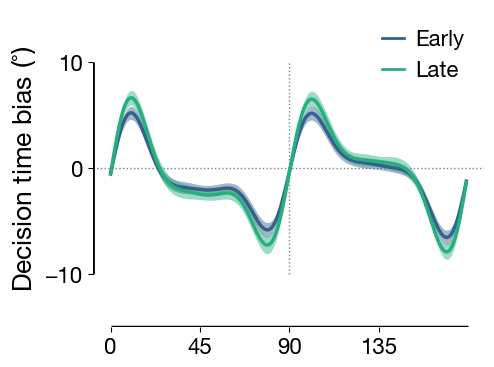

In [4]:
plt.figure()
ax = plt.gca()
utils.set_size([4,3])

plt.vlines(x=90, ymin=-10, ymax=10, linestyle='dotted', color='gray', linewidth=1.)
plt.axhline(y=0, linestyle='dotted', color='gray', linewidth=1., zorder=-3)

plt.fill_between(np.arange(180,step=0.75), 
                 m_ssb_fun[:,0]-s_ssb_fun[:,0], 
                 m_ssb_fun[:,0]+s_ssb_fun[:,0], 
                 color=utils.E_COLOR, alpha=0.45, linewidth=0)
plt.fill_between(np.arange(180,step=0.75), 
                 m_ssb_fun[:,1]-s_ssb_fun[:,1], 
                 m_ssb_fun[:,1]+s_ssb_fun[:,1], 
                 color=utils.L_COLOR, alpha=0.45, linewidth=0)

plt.plot(np.arange(180,step=0.75), m_ssb_fun[:,0], color=utils.E_COLOR, linewidth=2.5)
plt.plot(np.arange(180,step=0.75), m_ssb_fun[:,1], color=utils.L_COLOR, linewidth=2.5)

plt.ylim([-15,15])
plt.xticks([0,45,90,135])

line_e = mlines.Line2D([], [], color=utils.E_COLOR, label='Early', lw=2)
line_l = mlines.Line2D([], [], color=utils.L_COLOR, label='Late', lw=2)
plt.legend(handles=[line_e, line_l], handlelength=1, 
           frameon=False, loc='upper right', fontsize=16, handletextpad=0.5)

if utils.LABEL:
    # plt.xlabel(r"Orientation $(\!\!^\circ\!\!)$")
    plt.ylabel(r"Decision time bias $(\!\!^\circ\!\!)$")

utils.draw_publish_axis(ax, xrange=(0,180), yrange=(-10,10), xticks=None, yticks=[-10,0,10])
plt.savefig(f'{utils.DIR_FIGURE}/fig3a.pdf', bbox_inches='tight', transparent=True)
plt.show()

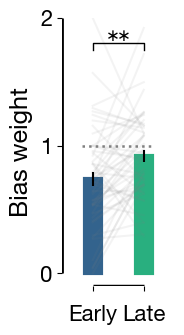

In [5]:
v_E = ssb_weight[:,0]
v_L = ssb_weight[:,1]

ms = [np.mean(v_E), np.mean(v_L)]
ss = [np.std(v_E)/np.sqrt(50), np.std(v_L)/np.sqrt(50)]

plt.figure()
ax = plt.gca()
utils.set_size([1.6,2.75])

xl, xr = -1, 1.5
for i in range(50):
    plt.plot([xl,xr], [v_E[i],v_L[i]], color='gray', alpha=0.09)
    
bar = plt.bar(x=[xl,xr], height=ms, color=[utils.E_COLOR, utils.L_COLOR])
bar[0].set_edgecolor(utils.E_COLOR)
bar[1].set_edgecolor(utils.L_COLOR)
bar[0].set_linewidth(3)
bar[1].set_linewidth(3)
plt.errorbar(x=[xl,xr], y=ms, yerr=ss, fmt="none", color="k")

plt.xlim([xl-1.5,xr+1.5])
plt.ylim([-0.1,2])

ax.hlines(y=1, xmin=xl-0.5, xmax=xr+0.5, linestyle='dotted', color='gray', linewidth=1.8, zorder=-3)

# Add significance asterisks
ax.plot([xl, xl, xr, xr], [1.75, 1.8, 1.8, 1.75], lw=1, c='k')
ax.text((xl+xr)/2., 1.8, r"$ {\ast\!\!\ast} $", ha='center', va='bottom', color='k', fontsize=12)

if utils.LABEL:
    plt.ylabel(r"Bias weight", labelpad=5, fontsize=18)
    plt.tick_params(axis='x', which='major', pad=10)
    plt.xticks([xl,xr], ['Early', 'Late'], fontsize=16)

utils.draw_publish_axis(ax, xrange=(xl,xr), yrange=(0,2), xticks=None, yticks=[0,1,2])
plt.savefig(f'{utils.DIR_FIGURE}/fig3b.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [6]:
ttest  = DescrStatsW(v_L-v_E)
wilcox = wilcoxon(v_L-v_E)
print("Bias weight: Early vs. Late")
print('\nPaired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Bias weight: Early vs. Late

Paired samples t-test
t(49)= 3.0982447318527884 p= 0.003220010896518406
95% CI= (0.06174598425286128, 0.2896998326599339)

Wilcoxon signed-rank test (without continuity correction)
V= 336.0 p= 0.003099259960384515


---

## Decision-consistent bias

In [7]:
%%capture
dcb_list = utils.nan((2,5,2,len(id_list)))
for i_id, v_id in enumerate(id_list): 
    for i_t, v_t in enumerate([1,2]):
        for i_r, v_r in enumerate([-21,-4,0,4,21]): 
            idx = (behavior.Timing==v_t) & (behavior.ID==v_id) & (behavior.ref== -v_r)
            dcb_list[i_t,i_r,0,i_id] = utils.circmean(behavior.error[idx&(behavior.choice==2)])
            dcb_list[i_t,i_r,1,i_id] = utils.circmean(behavior.error[idx&(behavior.choice==1)])

dcb_list[:,0,1] = np.nan # omit the 'lapse' (Far incorrect) conditions for visualization
dcb_list[:,4,0] = np.nan # omit the 'lapse' (Far incorrect) conditions for visualization
m_dcb_list = np.nanmedian(dcb_list,axis=-1)
s_dcb_list = np.nanstd(dcb_list,axis=-1)/np.sqrt(50)

In [8]:
dces_e = utils.nan([len(id_list),2]) # EL
dces   = utils.nan([len(id_list),2,2]) # EL, C/CW

for i_id, v_id in enumerate(id_list):
    sub_df = behavior[behavior.ID == v_id]
    _evi   = -sub_df.ref.to_numpy()
    _dm    = 2.-sub_df.choice.to_numpy()
    _time  = sub_df.Timing.to_numpy()
    _err   = sub_df.error.to_numpy()
    
    for i_t, v_t in enumerate([1,2]):
        idx = (_time==v_t) & (np.abs(_evi)<5)
        dces_e[i_id,i_t] = utils.circmean(_err[idx] * (2*_dm[idx]-1))
        dces[i_id,i_t,0] = utils.circmean(_err[idx&(_dm==1)])
        dces[i_id,i_t,1] = utils.circmean(_err[idx&(_dm==0)])

v_Ecw, v_Eccw = dces[:,0,0], dces[:,0,1]
v_Lcw, v_Lccw = dces[:,1,0], dces[:,1,1]

ms_cw  = [np.mean(v_Ecw), np.mean(v_Lcw)]
ss_cw  = [np.std(v_Ecw)/np.sqrt(50), np.std(v_Lcw)/np.sqrt(50)]
ms_ccw = [np.mean(v_Eccw), np.mean(v_Lccw)]
ss_ccw = [np.std(v_Eccw)/np.sqrt(50), np.std(v_Lccw)/np.sqrt(50)]

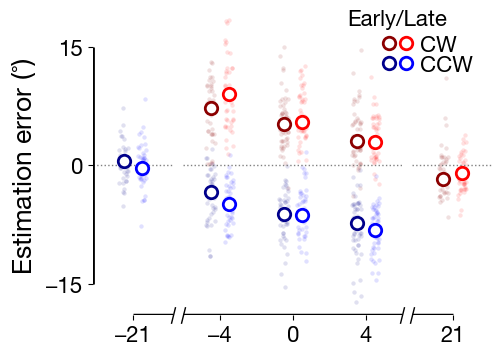

In [9]:
f,ax = plt.subplots(1,3, gridspec_kw={'width_ratios':[1.1,3,1.1]})
plt.subplots_adjust(wspace=0.08)
utils.set_size([4,3])

devi = 0.5 # deviation for scatter plot
for ifig in range(3):
    ax[ifig].axhline(y=0, linestyle='dotted', color='gray', linewidth=1.)

# figures
np.random.seed(2023)
for i_r, v_r in enumerate([-21,-4,0,4,21]):
    ifig = [0,1,1,1,2][i_r]

    # early
    ax[ifig].scatter(v_r-devi, m_dcb_list[0,i_r,1], color='white', edgecolor='darkred', zorder=3, lw=2, s=80)
    ax[ifig].scatter( np.array([v_r]*50)-devi+ np.random.uniform(-devi/2,devi/2,size=50), 
                      dcb_list[0,i_r,1,:], color='darkred', alpha=0.12, linewidth=0, s=10, zorder=0)
    ax[ifig].scatter(v_r-devi, m_dcb_list[0,i_r,0], color='white', edgecolor='darkblue', zorder=3, lw=2, s=80)
    ax[ifig].scatter( np.array([v_r]*50)-devi+ np.random.uniform(-devi/2,devi/2,size=50),
                      dcb_list[0,i_r,0,:], color='darkblue', alpha=0.12, linewidth=0, s=10, zorder=0)

    # late
    ax[ifig].scatter(v_r+devi, m_dcb_list[1,i_r,1], color='white', edgecolor='red', zorder=3, lw=2, s=80)
    ax[ifig].scatter( np.array([v_r]*50)+devi+ np.random.uniform(-devi/2,devi/2,size=50),
                      dcb_list[1,i_r,1,:], color='red', alpha=0.12, linewidth=0, s=10, zorder=0)
    ax[ifig].scatter(v_r+devi, m_dcb_list[1,i_r,0], color='white', edgecolor='blue', zorder=3, lw=2, s=80)
    ax[ifig].scatter( np.array([v_r]*50)+devi+ np.random.uniform(-devi/2,devi/2,size=50),
                      dcb_list[1,i_r,0,:], color='blue', alpha=0.12, linewidth=0, s=10, zorder=0)

# broken axis
d = 4.  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot(1,0,transform=ax[0].transAxes, **kwargs)
ax[1].plot(0,0,transform=ax[1].transAxes, **kwargs)
ax[1].plot(1,0,transform=ax[1].transAxes, **kwargs)
ax[2].plot(0,0,transform=ax[2].transAxes, **kwargs)

# 
ost = 2 # offset for broken axis
ax[0].set_xlim([-21-ost*1.1,-21+ost*1.1])
ax[1].set_xlim([-4-ost,4+ost])
ax[2].set_xlim([21-ost*1.1,21+ost*1.1])
for ifig in range(3):
    ax[ifig].set_ylim([-19,19])
    if ifig >= 1 :
        ax[ifig].spines['left'].set_visible(False)
        ax[ifig].set_yticks([])

# legend
from matplotlib.legend_handler import HandlerTuple
markerpar  = {'markeredgewidth': 2, 'markerfacecolor': 'white', 'markersize': 9, 'marker': 'o', 'linestyle': 'None'}
circ_red   = mlines.Line2D([], [], markeredgecolor='red', **markerpar)
circ_blue  = mlines.Line2D([], [], markeredgecolor='blue', **markerpar)
circ_dred  = mlines.Line2D([], [], markeredgecolor='darkred', **markerpar)
circ_dblue = mlines.Line2D([], [], markeredgecolor='darkblue', **markerpar)
plt.legend([(circ_dred,circ_red), (circ_dblue,circ_blue)], ['CW', 'CCW'] ,
           handler_map={tuple: HandlerTuple(ndivide=None)},
           frameon=False, loc='upper right', fontsize=16, handletextpad=0.45, handlelength=1.10, labelspacing=0.0)
plt.text(0.715, 0.87, 'Early/Late', ha='center', va='center', transform=f.transFigure, fontsize=16)


if utils.LABEL:
    # plt.xlabel(r"Relative orientation $(\!\!^\circ\!\!)$")    
    ax[0].set_ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    

utils.draw_publish_axis(ax[0], xrange=(-21,21), yrange=(-15,15), xticks=[-21], yticks=[-15,0,15], tight_layout=False)
utils.draw_publish_axis(ax[1], xrange=(-21,21), yrange=None, xticks=[-4,0,4], yticks=None, tight_layout=False)
utils.draw_publish_axis(ax[2], xrange=(-21,21), yrange=None, xticks=[21], yticks=None, tight_layout=False)
plt.savefig(f'{utils.DIR_FIGURE}/fig3c.pdf',bbox_inches='tight', transparent=True)
plt.show()

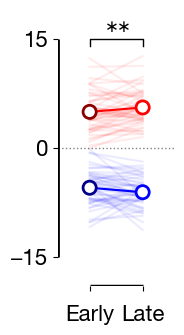

In [10]:
plt.figure()
ax = plt.gca()
utils.set_size([1.6,2.75])

xl, xr = -1, 1.5

plt.plot([xl, xr], [ms_cw[0], ms_cw[-1]],   color='red', zorder=0)
plt.plot([xl, xr], [ms_ccw[0], ms_ccw[-1]], color='blue', zorder=0)
plt.axhline(y=0,  linestyle='dotted', color='gray', linewidth=1.)

plt.errorbar(x=[xl], y=ms_cw[0], yerr=ss_cw[0], fmt="none", color="darkred")
plt.errorbar(x=[xr], y=ms_cw[-1], yerr=ss_cw[-1], fmt="none", color="red")
plt.scatter(x=[xl,xr], y=ms_cw, edgecolors=["darkred", "red"], s=90, color='white', zorder=3, lw=2)
for i in range(50):
    plt.plot([xl,xr], [v_Ecw[i],v_Lcw[i]], color='red', alpha=0.08)

plt.errorbar(x=[xl], y=ms_ccw[0], yerr=ss_ccw[0], fmt="none", color="darkblue")
plt.errorbar(x=[xr], y=ms_ccw[-1], yerr=ss_ccw[-1], fmt="none", color="blue")
plt.scatter(x=[xl,xr], y=ms_ccw, edgecolors=["darkblue", "blue"], s=90, color='white', zorder=3, lw=2)
for i in range(50):
    plt.plot([xl,xr], [v_Eccw[i],v_Lccw[i]], color='blue', alpha=0.08)  

plt.xlim([xl-1.5,xr+1.5])
plt.ylim([-19,19])

plt.plot([xl, xl, xr, xr], [14, 15, 15, 14], lw=1, c='k')
plt.text((xl+xr)/2., 15.5, r"$\,{\ast\!\!\ast}$", ha='center', va='bottom', color='k', fontsize=12)

if utils.LABEL:
    # plt.ylabel(r"Estimation error $(\!\!^\circ\!\!)$")    
    plt.tick_params(axis='x', which='major', pad=10)
    plt.xticks([xl,xr], ['Early', 'Late'], fontsize=16)

utils.draw_publish_axis(ax, xrange=(xl, xr), yrange=(-15,15), xticks=None, yticks=[-15,0,15])
plt.savefig(f'{utils.DIR_FIGURE}/fig3d.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [11]:
ttest  = DescrStatsW(dces_e[:,1]-dces_e[:,0])
wilcox = wilcoxon(dces_e[:,1]-dces_e[:,0])
print("Decision-consistent bias: Early vs. Late")
print('\nPaired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Decision-consistent bias: Early vs. Late

Paired samples t-test
t(49)= 2.9290381940376533 p= 0.005148292958772957
95% CI= (0.20351036171494968, 1.0930935224442342)

Wilcoxon signed-rank test (without continuity correction)
V= 320.0 p= 0.0017779629774352657
